In [31]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torchsummary import summary
from torch import optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tqdm import tqdm


In [32]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("gpu")
else:
    device = torch.device('cpu')
print(torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('CUDA version:', torch.version.cuda)
print('cuDNN version:', torch.backends.cudnn.version())

gpu
2.1.2+cu121
CUDA available: True
CUDA version: 12.1
cuDNN version: 8902


In [33]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [34]:
train_data.data.size()

torch.Size([60000, 28, 28])

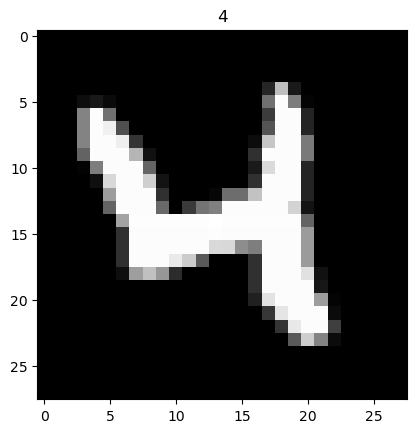

In [35]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[20], cmap='gray')
plt.title('%i' % train_data.targets[20])
plt.show()

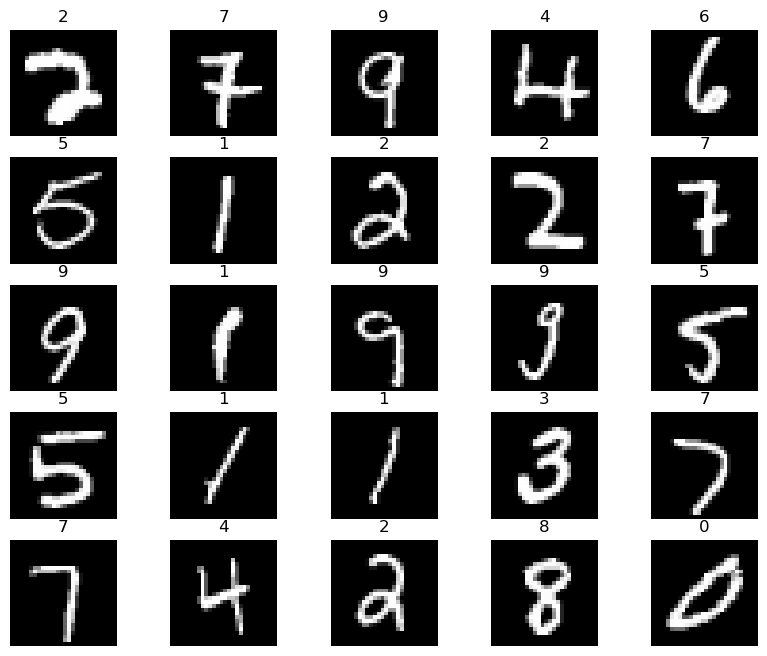

In [36]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [37]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f398d273f50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f398d58c090>}

<img src="../RNN/LSTM/images/Screenshot from 2024-02-05 16-28-23.png" alt="Alt text">

-  using two convolutional layers sequentially without a pooling layer in between:

- Increased Representation Power: Enhances the network's ability to learn more complex features.

- Preserving Spatial Resolution: Maintains higher resolution of feature maps, allowing the network to capture finer details.

- Enhanced Feature Extraction: Allows for more abstract and sophisticated feature extraction from the input data.

- Reduced Information Loss: Delays the downsampling and potential information loss that comes with pooling layers.

- Adjustable Receptive Field: Increases the receptive field without the need for larger convolutional kernels.

- Computational Considerations: Offers a manageable increase in computational complexity compared to larger kernels.

- Flexibility in Network Design: Provides an additional architectural choice for optimizing performance on specific tasks and datasets.

In [38]:
class CNN(nn.Module):
    def  __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )

        self.fc = nn.Linear(64*7*7, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)        

        output = self.fc(x)

        return output, x

In [39]:
cnn = CNN()
cnn = cnn.to(device)
cnn

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p

In [40]:
summary(cnn, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]          25,632
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
           Dropout-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          51,264
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]         102,464
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

In [41]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [42]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [43]:
from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        print(f"epoch {epoch}/{num_epochs}:")
        running_loss = .0

        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device)   # batch x
            b_y = Variable(labels).to(device)  # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            running_loss += loss.item()
                
        train_loss = running_loss/total_step
        print(f"Loss: {train_loss}")
    
train(num_epochs, cnn, loaders)

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 0/5:


Training Progress:  20%|██        | 1/5 [00:17<01:10, 17.61s/it]

Loss: 0.4863861872224758
epoch 1/5:


Training Progress:  40%|████      | 2/5 [00:35<00:52, 17.55s/it]

Loss: 0.06079138619786439
epoch 2/5:


Training Progress:  60%|██████    | 3/5 [00:52<00:35, 17.57s/it]

Loss: 0.043585180201916957
epoch 3/5:


Training Progress:  80%|████████  | 4/5 [01:10<00:17, 17.59s/it]

Loss: 0.03762680201383773
epoch 4/5:


Training Progress: 100%|██████████| 5/5 [01:27<00:00, 17.59s/it]

Loss: 0.032549450359801994


In [44]:
def test():
    # Test the model
    cnn.eval()

    running_loss = .0
    with torch.no_grad():
        correct = 0
        total = 0
        preds = []
        y_true = []
        for images, labels in loaders['test']:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)

            loss = loss_func(test_output,labels)
            running_loss += loss.item()

            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            preds.extend(pred_y.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
        test_loss = running_loss/len(loaders["test"])
        print(f'test_loss {test_loss}')

        return preds, y_true
    
preds, y_true = test()

test_loss 0.025817151474766434


In [45]:

accuracy = accuracy_score(y_true, preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Precision
precision = precision_score(y_true, preds, average='weighted', zero_division=0)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_true, preds, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_true, preds, average='weighted')
print(f'F1 Score: {f1:.4f}')

Accuracy: 99.15%
Precision: 0.9916
Recall: 0.9915
F1 Score: 0.9915
